<a href="https://colab.research.google.com/github/Hastighn/lung-cancer-treatment-agent-based-modeling/blob/main/Death_Rate%2C_Complete_ABS_Modeling_including_patient_as_agent_with_different_alpha_mode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Mesa

In [ ]:
!pip install -q mesa


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.0 MB/s

# Import Dependencies

In [ ]:
import mesa
import random
import numpy as np
import pandas as pd
from mesa.time import RandomActivation
from mesa.space import ContinuousSpace
import matplotlib.pyplot as plt
import math

# Patient class

In [ ]:
class Patient(mesa.Agent):
  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.agent_type = "Patient"
    self.closest_hospital_type = None
    self.closest_hospital_unique_id = 0
    self.entry_time = 0
    self.diagnosed_time = 0
    self.refer_to_T_time = 0
    self.refer_to_A_time = 0
    self.refer_to_WGS_time = 0
    self.patient_cost = 0
    self.waiting_time = 0
    self.waiting_cost = 0
    #This variable is for the patients who have not been diagnosed and they are supposed to be referred.
    self.ND = []
    self.diagnosed_status = "ND"    #D: Diagnosed   ND: Not Diagnosed
    self.living_status = "A"   #A: Alive    D:Dead
    self.dead_patient = 0
    self.diagnosed_location = None


# General Hospital class

In [ ]:
class GeneralHospital(mesa.Agent):
  def __init__(self, unique_id, model, G_success_rate, G_time, alpha, G_cost):
    super().__init__(unique_id, model)
    self.agent_type = "GeneralHospital"
    self.success_rate = G_success_rate
    self.initial_pG = []
    self.G_diagnosed = []
    self.closest_teaching_hospital = None
    self.closest_academic_hospital = None
    self.Gprocessing_time = G_time
    self.Alpha = alpha
    self.refer_to_A = []
    self.refer_to_T = []
    self.G_cost = G_cost
    self.G_entry_patient_cost = 0
    self.diagnosedcost = 0
    self.waiting_time = 0   #for all patient in General hospital
    self.referraltime = 0   #for a patient who referred from G to T or A
    self.initial_patients_cost = 0 #The total cost of all patients who visited a hospital for the firsttime until being diagnosed
    self.num_initial_p = 0 #number of total patients visiting G hospital for the first time
    self.waitingtime = 0
    #self.ND = []

  def step(self):
    self.initial_pG = []
    self.G_diagnosed = []
    for patient in self.model.schedule.agents:
      if patient.agent_type == "Patient" and patient.living_status == "A" and patient.closest_hospital_unique_id == self.unique_id and patient.closest_hospital_type == "GeneralHospital" and patient.entry_time == self.model.schedule.steps:
          self.initial_pG.append(patient.unique_id)
          patient.patient_cost += self.G_cost
          patient.waiting_time += self.Gprocessing_time
          self.num_initial_p += 1

    for patient in self.initial_pG:
        patient = self.model.get_patient_by_id(patient)
          #if self.model.schedule.steps == patient.entry_time:
             #self.Gfirst_visit.append(patient.unique_id)
             #print(f"Patient {patient.unique_id} is visiting General Hospital{self.unique_id} for the first time at step {self.model.schedule.steps}.")
        Random = np.random.rand()
        if Random <= self.success_rate:
          self.G_diagnosed.append(patient.unique_id)
          patient.diagnosed_time = self.model.schedule.steps
          patient.diagnosed_status = "D"
          patient.diagnosed_location = [self.unique_id, self.agent_type]
        else:
          patient.waiting_time += self.referraltime
          if np.random.rand() <= self.Alpha:
            self.refer_to_T.append([patient.unique_id, self.unique_id, self.model.schedule.steps])
            patient.refer_to_T_time = self.model.schedule.steps
              #This is the list fot patients who has not been diagnosed and they are supposed to be referred.
            patient.ND.append(["RT", patient.unique_id, self.model.schedule.steps])
          else:
            self.refer_to_A.append([patient.unique_id, self.unique_id, self.model.schedule.steps])
            patient.refer_to_A_time = self.model.schedule.steps
              #This is the list fot patients who has not been diagnosed and they are supposed to be referred.
            patient.ND.append(["RA", patient.unique_id, self.model.schedule.steps])

      #calculate total cost for all patients
    self.G_entry_patient_cost = self.G_cost * len(self.initial_pG)
    self.diagnosedcost = self.G_cost * len(self.G_diagnosed)
      #self.totalcost1 = self.G_cost * (len(self.G_diagnosed) + len(self.refer_to_T) + len(self.refer_to_A))

      #calcualte waiting time for all patients
    self.waiting_time = self.Gprocessing_time * (len(self.G_diagnosed) + len(self.refer_to_T) + len(self.refer_to_A)) + self.referraltime

# Teaching Hospital class

In [ ]:
class TeachingHospital(mesa.Agent):
  def __init__(self, unique_id, model, T_success_rate, T_time, T_cost):
    super().__init__(unique_id, model)
    self.agent_type = "TeachingHospital"
    self.success_rate = T_success_rate
    self.initial_pT = []
    self.T_diagnosed = []
    self.refer_from_G = []
    self.refer_to_A = []
    self.closest_academic_hospital = None
    self.total_p = []
    self.Tprocessing_time = T_time
    self.num_refer_from_G = 0
    self.T_cost = T_cost
    self.T_entry_patient_cost = 0
    self.T_refercost = 0
    self.diagnosedcost = 0
    self.totalcost = 0
    self.waiting_time = 0  #for all patient in Teaching hospital
    self.referwaiting_time = 0
    self.referraltime = 0
    self.initial_patients_cost = 0 #The total cost of all patients who visited a hospital for the firsttime until being diagnosed
    self.num_initial_p = 0 #number of total patients visiting T hospital for the first time
    self.waitingtime = 0
    #self.ND = []

  def step(self):
    self.initial_pT = []
    for patient in self.model.schedule.agents:
      if patient.agent_type == "Patient" and patient.closest_hospital_unique_id == self.unique_id and patient.closest_hospital_type == "TeachingHospital" and patient.entry_time == self.model.schedule.steps:
         #patient.living_status == "A"
         #patient.step()
        self.initial_pT.append(patient.unique_id)

  # Calculate total number of patients in the TeachingHospital
    self.total_p = self.refer_from_G + self.initial_pT
    self.T_diagnosed = []
    self.num_refer_from_G =len(self.refer_from_G)
    self.refer_from_G = []

    for patient in self.total_p:
      patient = self.model.get_patient_by_id(patient)
        #if self.model.schedule.steps == patient.entry_time:
           #patient.Tfirst_visit.append(patient.unique_id)
           #print(f"Patient {patient.unique_id} is visiting Teaching Hospital {self.unique_id}for the first time at step {self.model.schedule.steps}.")
      if patient is not None and patient.living_status == "A":# Check if the patient was found
        patient.patient_cost += self.T_cost
        patient.waiting_time += self.Tprocessing_time
        Random1 = np.random.rand()
        if Random1 <= self.success_rate:
          self.T_diagnosed.append(patient.unique_id)
          patient.diagnosed_time = self.model.schedule.steps
          patient.diagnosed_status = "D"
          patient.diagnosed_location = [self.unique_id, self.agent_type]
        else:
          patient.waiting_time += self.referraltime
          self.refer_to_A.append([patient.unique_id, self.unique_id, self.model.schedule.steps])
          patient.refer_to_A_time = self.model.schedule.steps
          patient.ND.append(["RA", patient.unique_id, self.model.schedule.steps])


    #calculate total cost for total patient and referred patient
    self.T_entry_patient_cost  = self.T_cost * len(self.initial_pT)
    self.T_refercost = self.T_cost * self.num_refer_from_G
    self.diagnosedcost = self.T_cost * len(self.T_diagnosed)
    self.totalcost = self.T_entry_patient_cost + self.T_refercost
    #calculate waiting time for Teaching hospital patient and referred patient
    self.waiting_time = self.Tprocessing_time * (len(self.initial_pT) + self.num_refer_from_G) # we do not have the referral time
    #self.referwaiting_time = self.Tprocessing_time * self.num_refer_from_G


# Academic Hospital class

In [ ]:
class AcademicHospital(mesa.Agent):
  def __init__(self, unique_id, model, A_success_rate, A_time, dr_lh, p_lh, A_cost):
    super().__init__(unique_id, model)
    self.agent_type = "AcademicHospital"
    self.success_rate = A_success_rate
    self.initial_pA = []
    self.refer_from_T = []
    self.refer_from_G = []
    #self.total_p_a = A_patient_accpt
    self.total_p = []
    self.physician_lh = dr_lh
    self.patient_lh = p_lh
    self.probability = self.patient_lh * self.physician_lh
    self.refer_to_WGS = []
    self.notdiagnosed = []
    self.A_diagnosed = []
    self.soc = []
    self.closest_wgs = None
    self.refer_from_WGS = []
    self.Aprocessing_time = A_time
    self.refer_fromT_history = []
    self.refer_fromG_history = []
    self.A_cost = A_cost
    self.A_entry_patient_cost = 0
    self.A_refercost = 0
    self.diagnosedcost = 0
    self.waiting_time = 0
    self.Greferwaiting_time = 0
    self.Treferwaiting_time = 0
    self.referraltime = 0
    self.initial_patients_cost = 0 #The total cost of all patients who visited a hospital for the first time until being diagnosed
    self.num_initial_p = 0 #number of total patients visiting A hospital for the first time
    self.waitingtime = 0
    self.totalcost = 0
    self.A_soc_patient_cost = 0
    #self.ND = []

  def step(self):
    self.initial_pA = []
    self.soc_patients = 0

    for patient in self.model.schedule.agents:
       if patient.agent_type == "Patient" and patient.closest_hospital_unique_id == self.unique_id and patient.closest_hospital_type == "AcademicHospital" and patient.entry_time == self.model.schedule.steps:
        self.initial_pA.append(patient.unique_id)

  # Calculate total number of patients in the AcademicHospital
    self.total_p = self.refer_from_G + self.refer_from_T + self.initial_pA + self.refer_from_WGS
    self.A_diagnosed = []
    self.soc = []
    self.refer_fromT_history = len(self.refer_from_T)
    self.refer_fromG_history=len(self.refer_from_G)
    self.refer_from_T = []
    self.refer_from_G = []
    self.refer_from_WGS = []

    for patient in self.total_p:
      patient = self.model.get_patient_by_id(patient)
       #if self.model.schedule.steps == patient.entry_time:
          #patient.Afirst_visit.append(patient.unique_id)
          #print(f"Patient {patient.unique_id} is visiting Academic Hospital{self.unique_id} for the first time at step {self.model.schedule.steps}.")

      if patient is not None and patient.living_status == "A": # Check if the patient was found

        Random = np.random.rand()
        if Random <= self.probability:
          patient.waiting_time += self.referraltime
          self.refer_to_WGS.append([patient.unique_id, self.unique_id, self.model.schedule.steps])
          patient.refer_to_WGS_time = self.model.schedule.steps
          patient.ND.append(["RWGS", patient.unique_id, self.model.schedule.steps ])
        else:
          patient.patient_cost += self.A_cost
          patient.waiting_time += self.Aprocessing_time
          self.soc_patients += 1
          self.soc.append([patient.unique_id, self.model.schedule.steps])
          Random3 = np.random.rand()
          if Random3 <= self.success_rate:
            self.A_diagnosed.append(patient.unique_id)
            patient.diagnosed_time = self.model.schedule.steps
            patient.diagnosed_status = "D"
            patient.diagnosed_location = [self.unique_id, self.agent_type]
          else:
            patient.waiting_time += self.referraltime
            self.refer_to_WGS.append([patient.unique_id, self.unique_id, self.model.schedule.steps])
            patient.refer_to_WGS_time = self.model.schedule.steps + self.Aprocessing_time
            patient.ND.append(["RWGS", patient.unique_id, self.model.schedule.steps ])
                #patient.ND.append([patient.unique_id, self.model.schedule.steps ])
                #patient.current_time = self.model.schedule.steps

       #calculate total cost for total patient and referred patient
      self.A_entry_patient_cost = self.A_cost * len(self.initial_pA)
      self.A_soc_patient_cost = self.A_cost * len(self.soc)
      self.A_refercost = self.A_cost * (self.refer_fromT_history + self.refer_fromG_history)
      self.totalcost = self.A_entry_patient_cost + self.A_soc_patient_cost + self.A_refercost
      self.diagnosedcost = self.A_cost * len(self.A_diagnosed)

       #calculate waiting time for Academic hospital patient and referred patient
      self.waiting_time = self.Aprocessing_time * (len(self.initial_pA) + self.refer_fromG_history)
      self.waiting_time = self.Aprocessing_time * (len(self.initial_pA) + self.refer_fromG_history + self.refer_fromT_history + len(self.refer_from_WGS) )
      self.Greferwaiting_time = self.Aprocessing_time * self.refer_fromG_history
      self.Treferwaiting_time = self.Aprocessing_time * self.refer_fromT_history



# WGS Facility class

In [ ]:
class WGSFacility(mesa.Agent):
  def __init__(self, unique_id, model, percentage, WGS_time, WGS_cost, capacity):
    super().__init__(unique_id, model)
    self.agent_type = "WGSFacility"
    self.refer_from_A = []
    self.tumor_percentage = percentage
    self.wgs_diagnosed = []
    self.refer_to_A = []
    self.total_p = []
    self.WGSprocessing_time = WGS_time
    self.refer_fromA_history = []
    self.WGS_cost = WGS_cost
    self.totalcost = 0
    self.waiting_time = 0
    self.capacity = capacity
    self.in_queue = []
    self.referraltime = 0
    self.wgs_patients = 0

  def step(self):

    #for patient in self.model.schedule.agents:
     #if patient.agent_type == "Patient" and patient.entry_time == self.model.schedule.steps:
      #self.total_wgs.append(patient.unique_id)

    self.total_p = self.in_queue + self.refer_from_A
    wgs_patients = len(self.refer_from_A)
    self.in_queue = []
    self.wgs_diagnosed = []
    #self.refer_fromA_history= len(self.refer_from_A)
    self.refer_from_A = []
    remaining_capacity = self.capacity

# Check if the patient was found
    for p in self.total_p:
      patient = self.model.get_patient_by_id(p[0])
      if patient is not None and patient.living_status == "A":

       if remaining_capacity == 0:
        self.in_queue.append([p[0], p[1]])
        patient.waiting_time += 1
       else:
        remaining_capacity -= 1
        patient.patient_cost += self.WGS_cost
        patient.waiting_time += self.WGSprocessing_time

        Random4 = np.random.rand()
        if Random4 <= self.tumor_percentage:
          self.wgs_diagnosed.append(patient.unique_id)
          patient.diagnosed_time = self.model.schedule.steps
          patient.diagnosed_status = "D"
          patient.diagnosed_location = [self.unique_id, self.agent_type]
        else:
          patient.waiting_time += self.referraltime
          self.refer_to_A.append([p[0], p[1], self.model.schedule.steps])

     #calculate total cost for total patient and referred patient
      self.totalcost = self.WGS_cost * len(self.total_p)

     #calculate waiting time
      self.waiting_time = self.WGSprocessing_time * len(self.refer_fromA_history)

# Model Class

In [ ]:
class HospitalModel(mesa.Model):
  def __init__(self, width, height,num_p, num_general, num_teaching, num_academic, num_wgs, max_steps, WGS_value, WGS_capacity, WGS_time, alpha_mode ): #
    super().__init__()
    self.width = width
    self.height = height
    self.num_p = num_p
    self.num_general = num_general
    self.num_teaching = num_teaching
    self.num_academic = num_academic
    self.num_wgs = num_wgs
    self.diagnosed_General = []
    self.diagnosed_Teaching = []
    self.diagnosed_Academic = []
    self.diagnosed_WGS = []
    self.totaldiagnosed = []
    self.wgs_diagnosed = []
    self.total_General = []
    self.total_Teaching = []
    self.total_Academic = []
    self.total_wg = []
    self.total = []
    self.refer_to_Teaching = []
    self.refer_to_Academic = []
    self.totalcost_g = []
    self.totalcost_t = []
    self.totalcost_a = []
    self.totalcost_wgs = []
    self.totalcost = []
    self.Gdiagnosedcost = []
    self.Tdiagnosedcost = []
    self.Tdignosedcost = []
    self.Adiagnosedcost = []
    self.totaldiagnosedcost = []
    #self.alpha_value = alpha_value
    self.max_steps = max_steps
    self.WGS_value = WGS_value
    self.dead_p = 0
    self.min_cost_g = 0
    self.alpha_mode = alpha_mode
    self.dead_list = []
    self.cost = []
    self.WGS_capacity = WGS_capacity
    self.WGS_time = WGS_time

    #initiate activation schedule
    self.space = ContinuousSpace(width, height, True)  # True makes the space toroidal
    self.schedule = mesa.time.RandomActivationByType(self)
    #self.grid = mesa.space.MultiGrid(width, height, True)


    #Initilizing Agents
    for unique_id in range(1, self.num_p + 1):
      patient = Patient(unique_id, self)
      self.schedule.add(patient)
      patient.entry_time = random.randint(0, self.max_steps)
      # Place the agent at a random continuous location
      x = random.uniform(0, self.space.x_max)
      y = random.uniform(0, self.space.y_max)
      # place_agent method adds the coordinate to the agent automatically
      self.space.place_agent(patient, (x, y))

    self.random.seed(100)
    for i in range(1, self.num_general + 1):
      #define a random number for generating alpha for each general hospital
        #alpha = np.random.rand()
        #alpha = 1
        alpha = self.set_alpha()
        G_hospital = GeneralHospital(i, self, G_success_rate=0.58, G_time = 15,  alpha = alpha, G_cost = 334.14)
        self.schedule.add(G_hospital)
        # Add the agent to a random grid cell
        x = random.uniform(0, self.space.x_max)
        y = random.uniform(0, self.space.y_max)
        # place_agent method adds the coordinate to the agent automatically
        self.space.place_agent(G_hospital, (x, y))

    for i in range(1, self.num_teaching + 1):
        T_hospital = TeachingHospital(i, self, T_success_rate = 0, T_time = 15, T_cost = 536.02)
        self.schedule.add(T_hospital)
        x = random.uniform(0, self.space.x_max)
        y = random.uniform(0, self.space.y_max)
        # place_agent method adds the coordinate to the agent automatically
        self.space.place_agent(T_hospital, (x, y))

    for i in range(1, self.num_academic + 1):
        A_hospital = AcademicHospital(i, self, A_success_rate = 0.6, A_time = 18, dr_lh = 1, p_lh = 1, A_cost = 536.02 )
        self.schedule.add(A_hospital)
        x = random.uniform(0, self.space.x_max)
        y = random.uniform(0, self.space.y_max)
        # place_agent method adds the coordinate to the agent automatically
        self.space.place_agent(A_hospital, (x, y))

    for i in range(1, self.num_wgs + 1):
        WGS = WGSFacility(i, self, percentage = 1, WGS_time = self.WGS_time, WGS_cost = self.WGS_value,capacity = self.WGS_capacity)
        self.schedule.add(WGS)
        x = random.uniform(0, self.space.x_max)
        y = random.uniform(0, self.space.y_max)
        # place_agent method adds the coordinate to the agent automatically
        self.space.place_agent(WGS, (x, y))



 #self.datacollector = mesa.DataCollector()


    #Calculate the closest hospital for patient
    for agent in self.schedule.agents:
        if agent.agent_type == "Patient":
           closest_hospital = None
           closest_hospital_unique_id = None
           closest_distance = 10000000000000000
           for hospital in self.schedule.agents:
               if hospital.agent_type in ["GeneralHospital", "TeachingHospital", "AcademicHospital"]:
                  distance = self.calculate_distance(agent.pos, hospital.pos)
                  if distance < closest_distance:
                   closest_distance = distance
                    #closest_hospital = (hospital.agent_type, hospital.unique_id)
                   closest_hospital_type = hospital.agent_type
                   closest_hospital_unique_id = hospital.unique_id

           agent.closest_hospital_type = closest_hospital_type
           agent.closest_hospital_unique_id = closest_hospital_unique_id
           #print(agent.unique_id)
           #print("closest hospital to patitnes:", agent.closest_hospital_type)
           #print("closest hospital to patitnes:", agent.closest_hospital_unique_id)

    for agent in self.schedule.agents:
        if agent.agent_type == "GeneralHospital":
           closest_teaching_hospital = None
           closest_academic_hospital = None
           closest_distanceT = float('inf')  # Initialize with a large value
           closest_distanceA = float('inf')
           for th  in self.schedule.agents:
               if th.agent_type == "TeachingHospital":
                   distance = self.calculate_distance(agent.pos, th.pos)
                   if distance < closest_distanceT:
                    closest_distanceT = distance
                    closest_teaching_hospital = th.unique_id
           agent.closest_teaching_hospital = closest_teaching_hospital

           for ac in self.schedule.agents:
                if ac.agent_type == "AcademicHospital":
                    distance = self.calculate_distance(agent.pos, ac.pos)
                    if distance <  closest_distanceA:
                     closest_distanceA = distance
                     closest_academic_hospital = ac.unique_id
           agent.closest_academic_hospital = closest_academic_hospital

    #Calculate the closest academic hospital for all teaching hospitals
    for agent in self.schedule.agents:
        if agent.agent_type == "TeachingHospital":
            closest_academic_hospital = None
            closest_distance = float('inf')  # Initialize with a large value
            for ac in self.schedule.agents:
                if ac.agent_type == "AcademicHospital":
                    distance = self.calculate_distance(agent.pos, ac.pos)
                    if distance < closest_distance:
                        closest_distance = distance
                        closest_academic_hospital = ac.unique_id
            agent.closest_academic_hospital = closest_academic_hospital

    for agent in self.schedule.agents:
        if agent.agent_type == "AcademicHospital":
            closest_wgs_facility = None
            closest_distance = float('inf')  # Initialize with a large value
            for wg in self.schedule.agents:
                if wg.agent_type == "WGSFacility":
                    distance = self.calculate_distance(agent.pos, wg.pos)
                    if distance < closest_distance:
                        closest_distance = distance
                        closest_wgs_facility = wg.unique_id
            agent.closest_wgs = closest_wgs_facility


    self.datacollector = mesa.DataCollector()

  #Calculate distances between hospitals and refer patients accordingly
  def calculate_distance(self, pos1, pos2):
    #Calculate the Euclidean distance between two positions.
    x1, y1 = pos1
    x2, y2 = pos2
    return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

  def get_patient_by_id(self, patient_id):
      for agent in self.schedule.agents:
          if agent.agent_type == "Patient" and agent.unique_id == patient_id:
              return agent
      return None  # If no patient is found with the given unique_id

  def set_alpha(self):
      if self.alpha_mode == 'one':
          return 1
      elif self.alpha_mode == 'zero':
          return 0
      elif self.alpha_mode == 'random':
          return np.random.rand()
      else:
          raise ValueError("Invalid alpha_mode. Choose from 'one', 'zero', or 'random'.")

  #Define the scenario
  def step(self):

    #for loop for agents which are patients and not diagnosed and with a probability change them to NDD.
    #random number for each patienst and equal or less than the sigmoid function valus then chnage the status
    #include the number of NDD in your report.
        dead_patients = []
        for agent in self.schedule.agents:
          if agent.agent_type == 'Patient' and agent.ND  and agent.living_status == "A" and self.schedule.steps - agent.entry_time > 0:
            #time_difference = self.schedule.steps - agent.entry_time
            #print("Current Time:", self.schedule.steps,"Entry Time:", agent.entry_time)
            # Baseline death probability that increases over time but not exponentially
            #baseline_death_prob = 0.01 + (time_difference * 0.001)
            # Add randomness to the death probability
            #death_prob = baseline_death_prob * random.uniform(0.8, 1.2)
            #sigmoid_value = 1/(8*(1 + np.exp(-time_difference* 0.01)))
            #print("SIGMOID:", sigmoid_value)
            #sigmoid_value = 1 / (1 + np.exp(-0.1 * (time_difference - 10)))
            # Adjust sigmoid value with more randomness
            #adjusted_sigmoid_value = sigmoid_value * random.uniform(0.5, 1.5)
            Random = np.random.rand()
            #print("RANDOM VALUE:", Random)
            if Random <= 0.0573:
            #if Random <= 0:
              agent.living_status = "D"    # D = Dead
              #print("LIVING STATUS:", agent.living_status)
              agent.dead_patient += 1
              dead_patients.append(self.dead_p)
              #self.dead_list.append(self.dead_p)
              #print("Number of dead patients:", self.dead_p)
              #print('dead list:', self.dead_list)
              #print("Not Diagnosed:", agent.ND)
              #dead_patients.append(agent.unique_id)
              agent.patient_cost += 100000
              #print('DEAD PATIENTS:', dead_patients)
            else:
              agent.living_status = "A"
              #print("LIVING STATUS:", agent.living_status)
        print('DEAD:', self.dead_p)
        print('dead list:', self.dead_list)


        for agent in self.schedule.agents:
          if agent.agent_type == "GeneralHospital":
            for th in self.schedule.agents:
              if th.agent_type == "TeachingHospital" and th.unique_id == agent.closest_teaching_hospital:
                #add referraltime here to the g processing time to alll of them
                refer_to_T  = [r[0] for r in agent.refer_to_T if self.schedule.steps-r[2]>= agent.Gprocessing_time + agent.referraltime]
                th.refer_from_G.extend(refer_to_T)
                agent.refer_to_T = [r for r in agent.refer_to_T if self.schedule.steps-r[2]< agent.Gprocessing_time + agent.referraltime]

            #if self.totalcost_g:
              #min_cost_g = min(self.totlcost_g)
              #print(f"The minimum cost for General Hospitals is: {min_cost}")

            for ac in self.schedule.agents:
              if ac.agent_type == "AcademicHospital" and ac.unique_id == agent.closest_academic_hospital:
                refer_to_A = [r[0] for r in agent.refer_to_A if self.schedule.steps - r[2] >= agent.Gprocessing_time + agent.referraltime]
                ac.refer_from_G.extend(refer_to_A)
                agent.refer_to_A = [r for r in agent.refer_to_A if self.schedule.steps - r[2] < agent.Gprocessing_time + agent.referraltime]

        for agent in self.schedule.agents:
          if agent.agent_type == "TeachingHospital":
            for ac in self.schedule.agents:
              if ac.agent_type == "AcademicHospital" and ac.unique_id == agent.closest_academic_hospital:
                refer_to_A = [r[0] for r in agent.refer_to_A if self.schedule.steps-r[2] >= agent.Tprocessing_time + agent.referraltime]
                ac.refer_from_T.extend(refer_to_A)
                agent.refer_to_A = [r for r in agent.refer_to_A if self.schedule.steps-r[2] < agent.Tprocessing_time + agent.referraltime]

        for agent in self.schedule.agents:
          if agent.agent_type == "AcademicHospital":
            for wg in self.schedule.agents:
              if wg.agent_type == "WGSFacility" and wg.unique_id == agent.closest_wgs:
                refer_to_WGS = [[r[0], r[1]] for r in agent.refer_to_WGS if self.schedule.steps-r[2] >=  agent.referraltime]
                wg.refer_from_A.extend(refer_to_WGS)
                agent.refer_to_WGS = [r for r in agent.refer_to_WGS if self.schedule.steps-r[2] <  agent.referraltime]

        for agent in self.schedule.agents:
          if agent.agent_type == "WGSFacility":
            for ac in self.schedule.agents:
              if ac.agent_type == "AcademicHospital":
                refer_to_A = [r[0] for r in agent.refer_to_A if ac.unique_id == r[1] and (self.schedule.steps-r[2] >= agent.WGSprocessing_time + agent.referraltime)]
                ac.refer_from_WGS.extend(refer_to_A)
                agent.refer_to_A = [r for r in agent.refer_to_A if not (ac.unique_id == r[1] and self.schedule.steps-r[2] >= agent.WGSprocessing_time + agent.referraltime)]
                # we want to know

        # Collect data and advance the schedule
        self.datacollector.collect(self)
        self.schedule.step()

        #Initialize an empty list to store costs and associated unique_ids
        self.hospitals_cost()
        costs = []
        #Iterate through all agents in the schedule
        for agent in self.schedule.agents :
          if agent.agent_type == "GeneralHospital":
            # Append cost and unique_id if the cost is greater than zero
            if agent.initial_patients_cost > 0 :
             costs.append((agent.initial_patients_cost / agent.num_initial_p, agent.unique_id, agent.Alpha))
        print('patient_cost:', costs)

        # Find the minimum cost among the valid cost
        if costs:
          min_cost, min_cost_unique_id, min_alpha = min(costs, key=lambda x: x[0])
          print('Minimum patient cost:', min_cost, 'Unique ID of minimum cost patient:', min_cost_unique_id, 'MIN ALPHA:', min_alpha)
        else:
          print('No valid patient costs found.')

        #for loop for agents which are general hospital, calculate lambda value and then calculate alpha
        for agent in self.schedule.agents:
          if agent.agent_type == "GeneralHospital" and agent.initial_patients_cost > 0:
            lambda_value =  1 / (1 + np.exp(-(agent.initial_patients_cost / agent.num_initial_p  -  min_cost)))
            agent.Alpha = lambda_value * agent.Alpha + (1 - lambda_value) * min_alpha

        diagnosedgeneral = 0
        diagnosedteaching = 0
        diagnosedacademic = 0
        diagnosedwgs = 0
        totalgeneral = 0
        totalteaching = 0
        totalacademic = 0
        totalwgs = 0
        #teachingrefer = 0
        total_diagnosed = 0
        totalcostg = 0
        totalcostt = 0
        totalcosta = 0
        totalcostwgs = 0
        generaldiagnosedcost = 0
        teachingdiagnosedcost = 0
        academicdiagnosedcost = 0
        cost = 0
        number_of_patients = 0
        number_of_diagnosed = 0
        number_of_notdiagnosed = 0
        numbe_of_dead_patient = 0

        #printing results

        for agent in self.schedule.agents:

          if agent.agent_type == "Patient" and agent.entry_time <= self.schedule.steps:
            cost = cost + (agent.patient_cost + agent.waiting_time * 100)
            number_of_patients += 1
            #print('************',agent.diagnosed_location, agent.ND)
            if agent.diagnosed_status =='D':
              number_of_diagnosed += 1
            else:
              number_of_notdiagnosed += 1
            if agent.living_status == "D":
              numbe_of_dead_patient = numbe_of_dead_patient + 1

            #print("Not Diagnosed:", agent.ND)
            #print("Not Diagnosed Dead:", agent.status)
            #print("Number of dead patients:", agent.NDD)

            #print("patient", agent.unique_id)
            #print("entry time:", agent.entry_time)
            #print("Patients visit General hospital for the first time:", agent.Gfirst_visit)
            #print("Patients visit Teaching hospital for the first time:", agent.Tfirst_visit)
            #print("Patients visit Academic hospital for the first time:", agent.Afirst_visit)
            #print("Status:", agent.status)
            #print('cost:', agent.patient_cost)

          #General Hospital
          if agent.agent_type == "GeneralHospital":
            diagnosedgeneral = diagnosedgeneral + len(agent.G_diagnosed)
            totalgeneral = totalgeneral + len(agent.initial_pG)
            generaldiagnosedcost = generaldiagnosedcost  + agent.diagnosedcost
            totalcostg = totalcostg + agent.G_entry_patient_cost

            print("\033[1mGeneral\033[0m", agent.unique_id)
            #print("Location:", agent.pos)
            #print("Total Patients:", len(agent.model.schedule.agents))
            print("First Time SelfAdmitted Patient:", len(agent.initial_pG) ) #"Patient_id:", agent.initial_pG
            #print("First Time SelfAdmitted Patient:", agent.initial_pG)
            #print("diagnosed:", len(agent.G_diagnosed),
                 #"Patient_id:", agent.G_diagnosed)
            print("referred to Teaching Hospital:", len( agent.refer_to_T),"Patient_id:",  agent.refer_to_T )
            #print("referred to Teaching Hospital:",  agent.refer_to_T)
            print("referred to Academic Hospital:", len(agent.refer_to_A),agent.refer_to_A )
            #print("closest Teaching:", agent.closest_teaching_hospital)
            #print("closest Academic:", agent.closest_academic_hospital)
            #print("Diagnosed cost:", agent.diagnosedcost)
            #print("Total cost:", agent.G_entry_patient_cost)
            #print("Waiting Time for patients:", agent.waiting_time)

          #Teaching Hospital
          elif agent.agent_type == "TeachingHospital":
            diagnosedteaching = diagnosedteaching + len(agent.T_diagnosed)
            totalteaching = totalteaching + len(agent.total_p)
            teachingdiagnosedcost= teachingdiagnosedcost + agent.diagnosedcost
            totalcostt = totalcostt + agent.totalcost
            print("\033[1mTeaching\033[0m", agent.unique_id)
            #print("Location:", agent.pos)
            print("Total patients:", len(agent.total_p)) #"patient_id:", agent.total_p
            print("First Time SelfAdmitted Patient:",len(agent.initial_pT)) #"Patient_id:", agent.initial_pT
            print( "referred from General Hospital:", agent.num_refer_from_G)
            #print("diagnosed:", len(agent.T_diagnosed),
            #"Patient_id:", agent.T_diagnosed)
            #print("diagnosed:", agent.T_diagnosed)
            print("referred to Academic Hospital:", len(agent.refer_to_A), agent.refer_to_A)
            #print("closest Academic:", agent.closest_academic_hospital)
            #print("Total cost for entry patient:", agent.T_entry_patient_cost)
            #print("Diagnosedcost:", agent.diagnosedcost)
            #print("Total cost for referred patient from General:", agent.T_refercost)
            #print("Waiting time")

          #Academic Hospital
          elif agent.agent_type == "AcademicHospital":
            diagnosedacademic = diagnosedacademic + len(agent.A_diagnosed)
            totalacademic = totalacademic + len(agent.total_p)
            academicdiagnosedcost = academicdiagnosedcost  + agent.diagnosedcost
            #totalcosta = totalcosta + agent.totalcost
            print("\033[1mAcademic\033[0m", agent.unique_id)
            #Print("Location:", agent.pos)
            print("Total patients:", len(agent.total_p), "patient_id:", agent.total_p)
            print("First Time SelfAdmitted Patient:", len(agent.initial_pA) ) #"Patient_id:", agent.initial_pA
            print("referred from Teaching Hospital:", agent.refer_fromT_history)
            print("referred from General Hospital:", agent.refer_fromG_history)
            #print("referred from General Hospital:", agent.refer_from_G)
            #print("diagnosed:", len(agent.A_diagnosed),"Patient_id:", agent.A_diagnosed)
            print("WGS Referral:", len(agent.refer_to_WGS))
            print("WGS Referral:", agent.refer_to_WGS)
            print("SoC Referral:", len(agent.soc))
            #print("Not diagnosed:", len(agent.notdiagnosed),agent.notdiagnosed )
            #print("Diagnosedcost:", agent.diagnosedcost)
            #print("Closest WGS Facility:",agent.closest_wgs)
            #print("Total cost:", agent.totalcost)

          # WGS Facility
          elif agent.agent_type == "WGSFacility":
            diagnosedwgs = diagnosedwgs + len(agent.wgs_diagnosed)
            totalwgs = totalwgs + agent.wgs_patients
            totalcostwgs = totalcostwgs + agent.totalcost
            print("\033[1mWGS Facility\033[0m", agent.unique_id)
            #print("Location:", agent.pos)
            print("Total Patients:", agent.wgs_patients)
            print("referred from Academic Hospital:", agent.wgs_patients)
            print("diagnosed:", len(agent.wgs_diagnosed))
            print("Refer to Academic Hospital:", len(agent.refer_to_A))
            #print("Total cost:", agent.totalcost)


        self.diagnosed_General.append(diagnosedgeneral)
        self.diagnosed_Teaching.append(diagnosedteaching)
        self.diagnosed_Academic.append(diagnosedacademic)
        self.diagnosed_WGS.append(diagnosedwgs)

        self.total_General.append(totalgeneral)
        self.total_Teaching.append(totalteaching)
        self.total_Academic.append(totalacademic)
        self.total_wg.append(totalwgs)

        #self.totalcost_g.append(totalcostg)
        #self.totalcost_t.append(totalcostt)
        #self.totalcost_a.append(totalcosta)
        #self.totalcost_wgs.append(totalcostwgs)
        self.cost.append([cost, number_of_patients, number_of_diagnosed, number_of_notdiagnosed, numbe_of_dead_patient ])

        self.Gdiagnosedcost.append(generaldiagnosedcost)
        self.Tdiagnosedcost.append(teachingdiagnosedcost)
        self.Adiagnosedcost.append(academicdiagnosedcost)



        self.totaldiagnosedcost = [x + y + z for x, y, z in zip(self.Gdiagnosedcost,
                                                               self.Tdiagnosedcost,
                                                               self.Adiagnosedcost)]

        self.totaldiagnosed = [x + y + z + w for x, y, z, w in zip(self.diagnosed_General,
                                                   self.diagnosed_Teaching,
                                                   self.diagnosed_Academic,
                                                   self.diagnosed_WGS)]

        self.total = [x + y + z + w for x, y, z, w in zip(self.total_General,
                                                   self.total_Teaching,
                                                   self.total_Academic,
                                                   self.total_wg)]



        #self.totalcost = [x + y + z + w for x, y, z, w in zip(self.totalcost_g,
                                                   #self.totalcost_t,
                                                   #self.totalcost_a,
                                                   #self.totalcost_wgs)]

        print("Total diagnosed patients at General Hospitals: ", self.diagnosed_General)
        print("Total diagnosed patients at Teaching Hospitals: ", self.diagnosed_Teaching)
        print("Total diagnosed patients at Academic Hospitals: ", self.diagnosed_Academic)
        print("Total diagnosed patients at WGS Facility:", self.diagnosed_WGS)
        print("Total Diagnosed:", np.cumsum(self.totaldiagnosed))
        print("Total patients at General Hospitals: ", self.total_General)
        print("Total patients at Teaching Hospitals: ", self.total_Teaching)
        print("Total patients at Academic Hospitals: ", self.total_Academic)
        print("Total patients at WGS Facility:", self.total_wg)
        print('COST:', self.cost)
        #print("Total Dignosed Patienes for all hospitals:", self.totaldiagnosed)
        #print("Total cost for all General Hospitals:",self.totalcost_g )
        #print("Total cost for all Teaching Hospitals:",self.totalcost_t)
        #print("Total cost for all Academic Hospitals:",self.totalcost_a)
        #print("Total cost for all WGS Facilities:",self.totalcost_wgs)



  # Visualizing Function
  # Visualize hospitals on the map
  def visualize_hospitals(self):
    general_positions = [(agent.pos[0], agent.pos[1]) for agent in self.schedule.agents if agent.agent_type == "GeneralHospital"]
    teaching_positions = [(agent.pos[0], agent.pos[1]) for agent in self.schedule.agents if agent.agent_type == "TeachingHospital"]
    academic_positions = [(agent.pos[0], agent.pos[1]) for agent in self.schedule.agents if agent.agent_type == "AcademicHospital"]
    wgs_positions = [(agent.pos[0], agent.pos[1]) for agent in self.schedule.agents if agent.agent_type == "WGSFacility"]
    patient = [(agent.pos[0], agent.pos[1]) for agent in self.schedule.agents if agent.agent_type == "Patient"]
    plt.figure(figsize=(5, 3))
    if general_positions:
      plt.scatter(*zip(*general_positions), color='red', marker='s', label='General Hospital' , s = 120 )
    if teaching_positions:
      plt.scatter(*zip(*teaching_positions), color='green', marker='s', label='Teaching Hospital' , s = 120)
    if academic_positions:
      plt.scatter(*zip(*academic_positions), color='blue', marker='s', label='Academic Hospital' , s = 120)
    if wgs_positions:
      plt.scatter(*zip(*wgs_positions), color='yellow', marker='s', label='WGS Facility' , s = 120)
    if patient:
      plt.scatter(*zip(*patient), color='black', marker='o', label='patient' , s = 3)
      plt.title("Hospital & Patient Positions")
      plt.xlabel("X-coordinate")
      plt.ylabel("Y-coordinate")
      plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
      #plt.grid(True)

  # Graph for number of diagnosed patient for each hospita. It is not cumulative.
  def diagnosed_for_each_hospital(self):
      plt.figure(figsize=(5, 3))
      plt.plot(self.diagnosed_General, label='General Hospital', color='red')
      plt.plot(self.diagnosed_Teaching, label='Teaching Hospital', color='green')
      plt.plot(self.diagnosed_Academic, label='Academic Hospital', color='blue')
      plt.plot(self.diagnosed_WGS, label = 'WGS Facility', color = 'yellow')
      plt.title('Diagnosed Patients Over Time')
      plt.xlabel('Time Steps')
      plt.ylabel('Number of Diagnosed Patients')
      plt.legend()
      #plt.grid(True)
      plt.show()


  #Graph for cumulative number of dead patients
  def cumulative_dead_p(self):
    plt.figure(figsize = (5, 3))
    plt.plot(self.dead_list, label = 'Dead Patients', color = 'black')
    plt.title ( 'Cumulative Dead Patients')
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Dead Patients')
    #plt.grid(True)
    plt.show()

  # Graph for cumulative number of diagnosed patients for each hospital.
  def cumulative_diagnosed_for_each_hospital(self):
    cumulative_diagnosed_g = np.cumsum(self.diagnosed_General)
    cumulative_diagnosed_t = np.cumsum(self.diagnosed_Teaching)
    cumulative_diagnosed_a = np.cumsum(self.diagnosed_Academic)
    cumulative_diagnosed_wgs = np.cumsum(self.diagnosed_WGS)
    plt.figure(figsize=(5, 3))
    plt.plot(cumulative_diagnosed_g, label = 'General Hospital', color = 'red')
    plt.plot(cumulative_diagnosed_t, label = 'Teaching Hospital', color = 'green')
    plt.plot(cumulative_diagnosed_a, label = 'Academic Hospital', color = 'blue')
    plt.plot(cumulative_diagnosed_wgs, label = 'WGS Facility', color = 'yellow')
    plt.title('Cumulative Diagnosed Patients Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Number of diagnosed patients')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.show()

 # Graph for total number of diagnosed patients for all hospitals. It is not cumulative.
  def total_diagnosed(self):
      plt.figure(figsize=(5, 3))
      plt.plot(self.totaldiagnosed, label= 'total Diagnosed', color = 'black')
      plt.title ('Total number of Diagnosed Patients')
      plt.xlabel('Time Steps')
      plt.ylabel('Number of Total Diagnosed patient')
      #plt.grid(True)
      plt.show()

  # Graph for cumulative total number of diagnosed patients for all hospitals.
  def cumulative_total_diagnosed(self):
    cumulative_diagnosed = np.cumsum(self.totaldiagnosed)
    plt.figure(figsize=(5, 3))
    plt.plot(cumulative_diagnosed, label= 'Total Diagnosed', color = 'black')  # ls = ':'
    plt.title ('Cumulative Total Number of Diagnosed Patients')
    plt.xlabel('Time Steps')
    plt.ylabel('Number of total diagnosed patients')
    #plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.show()


  def diagnosed_cost(self):
    plt.figure(figsize = (5, 3))
    plt.plot(self.cost, label = 'Diagnosed Cost', color = 'black')
    plt.title ('Diagnosed Cost')
    plt.xlabel('Time Steps')
    plt.ylabel('Cost')
    plt.grid(True)
    plt.show()

  def cumulative_diagnosed_cost(self):
    plt.figure(figsize = (5, 3))
    cumulative_cost = np.cumsum(self.cost)
    plt.plot(cumulative_cost, label = 'Cumulative Diagnosed Cost', color = 'black', ls = ':')
    plt.title ('Cumulative Diagnosed Cost')
    plt.xlabel('Time Steps')
    plt.ylabel('Cost')
    #plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.show()

  # Graph for number of patients for each hospital. It is not cumulative.
  def total_patients_for_each_hospital(self):
      plt.figure(figsize=(5, 3))
      plt.plot(self.total_General, label='General Hospital', color='red')
      plt.plot(self.total_Teaching, label='Teaching Hospital', color='green')
      plt.plot(self.total_Academic, label='Academic Hospital', color='blue')
      plt.plot(self.total_wg, label= 'WGS Facility', color = 'yellow')
      plt.title('Total Patients Over Time')
      plt.xlabel('Time Steps')
      plt.ylabel('Number of Total Patients')
      plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
      #plt.grid(True)
      plt.show()

  # Graph for cumulative number of patients for each hospital.
  def cumulative_total_patients_for_each_hospital(self):
    cumulative_g = np.cumsum(self.total_General)
    cumulative_t = np.cumsum(self.total_Teaching)
    cumulative_a = np.cumsum(self.total_Academic)
    cumulative_wgs = np.cumsum(self.total_wg)
    plt.figure(figsize=(5, 3))
    plt.plot(cumulative_g, label = 'General Hospital', color = 'red')
    plt.plot(cumulative_t, label = 'Teaching Hospital', color = 'green')
    plt.plot(cumulative_a, label = 'Academic Hospital', color = 'blue')
    plt.plot(cumulative_wgs, label = 'WGS Facility', color = 'yellow')
    plt.title('Cumulative General Hospital Total Patients Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Total patient')
    #plt.grid(True)
    plt.show()


  # Graph for number of total patients for all hospitals. It is not cumulative.
  def total_patient(self):
      plt.figure(figsize=(5, 3))
      plt.plot(self.total, label= 'total Diagnosed', color = 'black')
      plt.title ('Total number of Patients')
      plt.xlabel('Time Steps')
      plt.ylabel('Number of Total patient')
      #plt.grid(True)
      plt.show()

  # Graph for cumulative total number of patients for all hospitals.
  def cumulative_patient(self):
    cumulative_patient = np.cumsum(self.total)
    plt.figure(figsize=(5, 3))
    plt.plot(cumulative_patient, label= 'Total Patients for all Hospitals', color = 'black')
    plt.title ('Cumulative Total number of Patients')
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Total patient')
    #plt.grid(True)

  # Graph for total cost for each hospital. It is not cumulative.
  def total_cost_for_each_hospital(self):
      plt.figure(figsize = (5, 3))
      plt.plot(self.totalcost_g, label = 'General Hospital', color = 'red')
      plt.plot(self.totalcost_t, label = 'Teahing Hospital', color = 'green')
      plt.plot(self.totalcost_a, label = 'Academic Hospital', color = 'blue')
      plt.plot(self.totalcost_wgs, label = 'WGS Facility', color = 'yellow')
      plt.title('Total cost for each hospital')
      plt.xlabel('Time Steps')
      plt.ylabel('Cost of each Hospital')
      plt.legend()
      #plt.grid(True)
      plt.show()

  # Graph for cumulative total cost for each hospital.
  def cumulative_total_cost_for_each_hospital(self):
    cumulative_cost_g = np.cumsum(self.totalcost_g)
    cumulative_cost_t = np.cumsum(self.totalcost_t)
    cumulative_cost_a = np.cumsum(self.totalcost_a)
    cumulative_cost_wgs = np.cumsum(self.totalcost_wgs)
    plt.figure(figsize=(5, 3))
    plt.plot(cumulative_cost_g, label = 'General Hospital', color = 'red')
    plt.plot(cumulative_cost_t, label = 'Teahing Hospital', color = 'green')
    plt.plot(cumulative_cost_a, label = 'Academic Hospital', color = 'blue')
    plt.plot(cumulative_cost_wgs, label = 'WGS Facility', color = 'yellow')
    plt.title('Cumulative Total cost for each hospital')
    plt.xlabel('Time Steps')
    plt.ylabel('Cost of each Hospital')
    plt.legend()
    #plt.grid(True)
    plt.show()

  # Graph for total cost for all hospitals. It is not cumulative.
  def total_cost(self):
      plt.figure(figsize=(5, 3))
      plt.plot( [a[0] for a in self.cost], color = 'black')
      plt.title ('Total cost for all hospitals')
      plt.xlabel('Time Steps')
      plt.ylabel('Total Cost')
      #plt.grid(True)
      plt.show()

  # Graph for cumulative total cost for all hospitals.
  def cumulative_total_cost(self):
    cumulative_cost = np.cumsum(self.totalcost)
    plt.figure(figsize=(5, 3))
    plt.plot(cumulative_cost, color = 'black')
    plt.title ('Cumulative Total cost for all hospitals')
    plt.xlabel('Time Steps')
    plt.ylabel('Total Cost')
    #plt.grid(True)
    plt.show()

  def hospitals_cost(self):
    for agent in self.schedule.agents:
      if agent.agent_type == "GeneralHospital" or agent.agent_type == "TeachingHospital" or agent.agent_type == "AcademicHospital":
        for patient in self.schedule.agents:
          if (patient.agent_type == "Patient" and
            patient.closest_hospital_unique_id == agent.unique_id and
            patient.closest_hospital_type == agent.agent_type):
            agent.initial_patients_cost += patient.patient_cost
        print(agent.agent_type, agent.unique_id, ":", agent.initial_patients_cost)
        print('NUM:', agent.num_initial_p)

  def hospitals_waitingtime(self):
    for agent in self.schedule.agents:
      if agent.agent_type == "GeneralHospital" or agent.agent_type == "TeachingHospital" or agent.agent_type == "AcademicHospital":
        for patient in self.schedule.agents:
          if (patient.agent_type == "Patient" and
            patient.closest_hospital_unique_id == agent.unique_id and
            patient.closest_hospital_type == agent.agent_type):
            agent.waitingtime += patient.waiting_time
        print(agent.agent_type, agent.unique_id,":", agent.waitingtime )



In [ ]:
refer_to_A = [[762, 1, 90],[762, 2, 90], [990, 1, 96], [1419, 1, 97]]
refer_to_A = [r for r in refer_to_A if not (1 == r[1] and 90-r[2] >= 0)]
print(refer_to_A)

[[762, 2, 90], [990, 1, 96], [1419, 1, 97]]


#Model without alpha mode

In [ ]:
# Create an instance of the model
max_steps = 100
#alpha_modes = ['zero']
WGS_value = 2925.25
model = HospitalModel(10,10,1700,6, 3, 1, 1, max_steps, WGS_value) #Senario1
#model2 = HospitalModel(10,10, 1,1,1,1, 0)

# Run the model
for i in range(max_steps):
    print("\033[1mstep\033[0m:", i)
    model.step()


TypeError: HospitalModel.__init__() missing 1 required positional argument: 'alpha_mode'

# Model with alpha mode zero and one

Streaming output truncated to the last 5000 lines.
DEAD: 0
dead list: []
GeneralHospital 1 : 395206985.7899191
NUM: 141
GeneralHospital 2 : 1057266014.0795652
NUM: 493
GeneralHospital 3 : 470072282.73987466
NUM: 203
GeneralHospital 4 : 209685297.9699759
NUM: 66
GeneralHospital 5 : 648959936.7798303
NUM: 222
GeneralHospital 6 : 894816336.1396846
NUM: 381
TeachingHospital 1 : 2231657387.7495756
NUM: 0
TeachingHospital 2 : 1472043108.249739
NUM: 0
TeachingHospital 3 : 1635809315.9497025
NUM: 0
AcademicHospital 1 : 722980652.25
NUM: 0
patient_cost: [(2802886.4240419795, 1, 0.28083924376283675), (2144555.8094920185, 2, 0.447716005536836), (2315627.0085708112, 3, 0.33571664990008615), (3177049.9692420587, 4, 0.47628227660557865), (2923242.9584677042, 5, 0.300033081203937), (2348599.3074532403, 6, 0.29493540469179946)]
Minimum patient cost: 2144555.8094920185 Unique ID of minimum cost patient: 2 MIN ALPHA: 0.447716005536836
General 1
First Time SelfAdmitted Patient: 0
referred to Teaching Hos

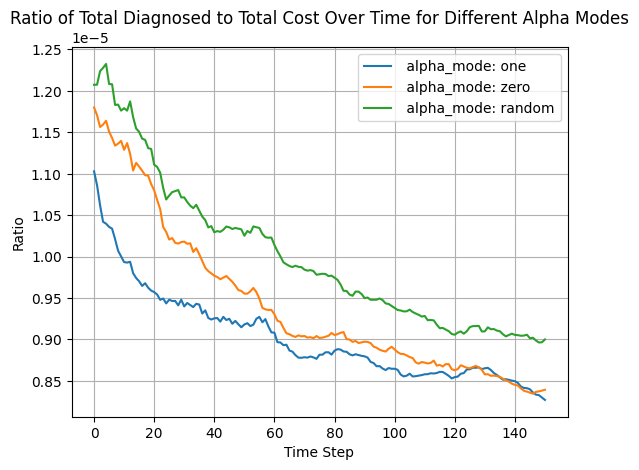

In [ ]:
plt.figure()
alpha_modes = ['one', 'zero', 'random']
#alpha_modes = [  'zero', 'one' ]
max_steps = 200
WGS_value = 2925.25
WGS_capacity = 4
WGS_time = 14
for alpha_mode in alpha_modes:
  print(f'Running model with alpha_mode={alpha_mode}')
  random.seed(1000)
  model = HospitalModel(10, 10, 3400, 6, 3, 1, 1, max_steps, WGS_value, WGS_capacity,WGS_time, alpha_mode)
  ratios = []

  for _ in range(max_steps):
    model.step()
    if model.cost[-1] != 0:# Check to avoid division by zero
      #ratio = sum(model.totaldiagnosed) / model.cost[-1]
      #change the line below to diagnosed to cost. the more is better
      ratio = model.cost[-1][2] / model.cost[-1][0]
      #ratio = model.cost[-1] / sum(model.totaldiagnosed)
      print(sum(model.totaldiagnosed), model.cost[-1])
    else:
      ratio = 0  # Assign zero if total cost is zero
    ratios.append(ratio)
    print('RATIOS:', ratios)

  # Plot the line for the current alpha mode
  plt.plot(ratios[49:], label=f' alpha_mode: {alpha_mode}')
    #plt.plot(ratios, label=f'alpha_mode={alpha_mode}'

#plt.plot(ratios, label=f'alpha_mode={alpha_mode}')
plt.title('Ratio of Total Diagnosed to Total Cost Over Time for Different Alpha Modes')
plt.xlabel("Time Step")
plt.ylabel("Ratio")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

#Model with alpha mode random

Streaming output truncated to the last 5000 lines.
GeneralHospital 2 : 4862281.240000004
NUM: 35
GeneralHospital 3 : 27452285.880000554
NUM: 100
GeneralHospital 4 : 1851583.5499999875
NUM: 25
GeneralHospital 5 : 43707205.7900014
NUM: 197
GeneralHospital 6 : 5518119.649999981
NUM: 46
TeachingHospital 1 : 17524758.539999373
NUM: 0
TeachingHospital 2 : 8040666.999999916
NUM: 0
TeachingHospital 3 : 9805301.689999769
NUM: 0
AcademicHospital 1 : 25138140.259999912
NUM: 0
patient_cost: [(238694.8013888951, 1, 0.4529046837522838), (138922.32114285725, 2, 0.3563017478983128), (274522.8588000055, 3, 0.7581869210283727), (74063.3419999995, 4, 0.46617400136876935), (221863.988781733, 5, 0.3437569321141042), (119959.12282608655, 6, 0.3161455332712706)]
Minimum patient cost: 74063.3419999995 Unique ID of minimum cost patient: 4 MIN ALPHA: 0.46617400136876935
General 1
First Time SelfAdmitted Patient: 3
referred to Teaching Hospital: 9 Patient_id: [[1645, 1, 31], [407, 1, 33], [173, 1, 36], [1398, 1,

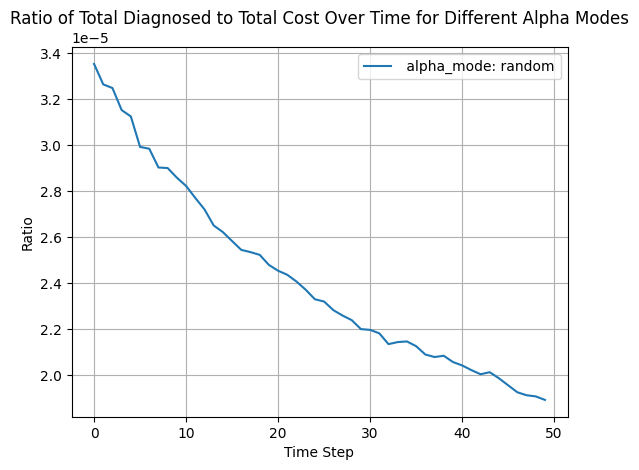

In [ ]:
plt.figure()
alpha_modes = ['random']
max_steps = 100
WGS_value = 2925.25

for alpha_mode in alpha_modes:
  print(f'Running model with alpha_mode={alpha_mode}')
  random.seed(1000)
  model = HospitalModel(10, 10, 1700, 6, 3, 1, 1, max_steps, WGS_value, alpha_mode)
  ratios = []

  for _ in range(max_steps):
    model.step()
    if model.cost[-1] != 0:# Check to avoid division by zero
      ratio = sum(model.totaldiagnosed) / model.cost[-1]
      #ratio = model.cost[-1] / sum(model.totaldiagnosed)
      print(sum(model.totaldiagnosed), model.cost[-1])
    else:
      ratio = 0  # Assign zero if total cost is zero
    ratios.append(ratio)
    print('RATIOS:', ratios)

  # Plot the line for the current alpha mode
  plt.plot(ratios[50:], label=f' alpha_mode: {alpha_mode}')
    #plt.plot(ratios, label=f'alpha_mode={alpha_mode}'

#plt.plot(ratios, label=f'alpha_mode={alpha_mode}')
plt.title('Ratio of Total Diagnosed to Total Cost Over Time for Different Alpha Modes')
plt.xlabel("Time Step")
plt.ylabel("Ratio")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Model with alpha mode comparing total diagnosed patients

Streaming output truncated to the last 5000 lines.
Total patients at Teaching Hospitals:  [1, 3, 3, 1, 1, 2, 3, 1, 1, 4, 1, 1, 1, 5, 3, 5, 5, 4, 2, 6, 4, 7, 4, 4, 3, 4, 7, 5, 3, 8, 5, 5, 8, 6, 2, 3, 4, 5, 8, 1, 5, 3, 7, 1, 5, 2, 3, 10, 6, 5, 6, 5, 3, 2, 5, 6, 8, 6, 3, 8, 3, 5, 8, 6, 4, 9, 3, 6, 2, 2, 4, 5, 3, 2, 7, 5, 5, 2, 3, 5, 5, 3, 7, 3, 5, 6, 6, 5, 2, 6, 6, 2, 6, 5, 7, 4, 5, 5, 7, 4, 6, 6, 5, 3, 3, 11, 5, 8, 6, 4, 6, 9, 4, 6, 5, 4, 4, 7, 4, 5, 4, 5, 3, 5, 4, 2, 4, 5, 5, 3, 5, 4, 12, 5, 5, 4, 1, 9, 7, 3, 5, 8, 5, 3, 6, 4, 3, 7, 6]
Total patients at Academic Hospitals:  [1, 3, 1, 2, 2, 2, 0, 1, 0, 3, 0, 1, 4, 1, 0, 6, 11, 7, 4, 6, 9, 9, 3, 4, 11, 3, 3, 5, 10, 10, 6, 13, 3, 5, 7, 4, 10, 5, 6, 9, 5, 14, 8, 5, 9, 10, 8, 10, 14, 8, 9, 6, 6, 6, 7, 10, 7, 15, 3, 9, 5, 4, 9, 11, 9, 7, 10, 6, 8, 5, 7, 7, 11, 7, 10, 10, 5, 5, 10, 9, 12, 10, 6, 7, 3, 6, 11, 10, 4, 7, 6, 8, 5, 5, 10, 6, 4, 9, 4, 9, 5, 9, 7, 9, 9, 12, 5, 12, 8, 10, 4, 7, 7, 3, 8, 7, 5, 8, 6, 7, 13, 11, 13, 9, 8, 11, 14, 5, 5, 7

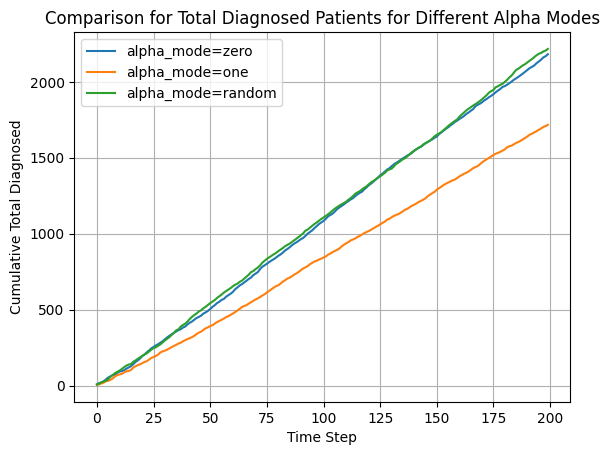

In [ ]:
plt.figure()
alpha_modes = ['zero','one', 'random']
#alpha_modes = [ 'random' ]
max_steps = 200
WGS_value = 2925.25
WGS_capacity = 4
WGS_time = 14

for alpha_mode in alpha_modes:
  print(f'Running model with alpha_mode={alpha_mode}')
  #random.seed(1000)
  model = HospitalModel(10, 10,3400, 6, 3, 1, 1, max_steps, WGS_value,WGS_capacity, WGS_time, alpha_mode)

  for _ in range(max_steps):
    model.step()
  # Plot the line for the current alpha mode
    #cumulative_diagnosed = np.cumsum(model.totaldiagnosed)
    #series = pd.Series(model.totaldiagnosed)
    #cumulative_diagnosed = series.iloc[49:].tolist()
    #cumulative_diagnosed = series.iloc[49:].cumsum().tolist()
    #plt.plot(cumulative_diagnosed, label=f'alpha_mode={alpha_mode}')
  plt.plot([sublist[2] for sublist in model.cost], label=f'alpha_mode={alpha_mode}')
    #plt.plot(sum(model.totaldiagnosed[50:]), label=f'alpha_mode={alpha_mode}')

#plt.plot(ratios, label=f'alpha_mode={alpha_mode}')
plt.title('Comparison for Total Diagnosed Patients for Different Alpha Modes')
plt.xlabel("Time Step")
plt.ylabel("Cumulative Total Diagnosed")
plt.legend(loc='upper left')
plt.grid(True)

Streaming output truncated to the last 5000 lines.
Total patients at Teaching Hospitals:  [7, 11, 2, 3, 2, 4, 4, 7, 8, 4, 5, 5, 3, 11, 7, 5, 12, 12, 21, 7, 11, 11, 6, 9, 11, 8, 10, 10, 4, 11, 11, 18, 15, 5, 3, 6, 11, 5, 11, 12, 9, 11, 13, 12, 10, 8, 11, 11, 15, 6, 12, 10, 15, 12, 10, 6, 5, 14, 14, 14, 13, 14, 10, 16, 7, 11, 9, 13, 6, 4, 8, 10, 15, 9, 9, 8, 6, 8, 10, 8, 8, 8, 12, 9, 9, 8, 10, 2, 8, 8, 10, 7, 16, 9, 12, 10, 7, 12, 9, 7, 9, 11, 9, 8, 9, 7, 14, 9, 9, 15, 7, 10, 14, 9, 7, 9, 7, 13, 12, 15, 7, 10, 14, 6, 6, 7, 10, 12, 7, 10, 7, 14, 10, 13, 7, 14, 10, 12, 11, 13, 11, 10, 9, 8, 9, 8, 14, 9, 9]
Total patients at Academic Hospitals:  [0, 1, 0, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 7, 13, 2, 5, 2, 4, 4, 7, 8, 6, 5, 5, 3, 11, 8, 7, 11, 6, 18, 6, 12, 5, 7, 7, 11, 5, 11, 7, 3, 7, 8, 14, 12, 3, 1, 6, 11, 5, 10, 12, 10, 7, 10, 10, 10, 7, 10, 12, 14, 5, 10, 8, 12, 10, 7, 5, 6, 13, 9, 11, 11, 10, 6, 12, 8, 8, 8, 14, 6, 4, 6, 9, 12, 5, 9, 10, 4, 6, 8, 7, 7, 10, 9, 5, 7, 7, 10, 2, 7, 6, 8, 

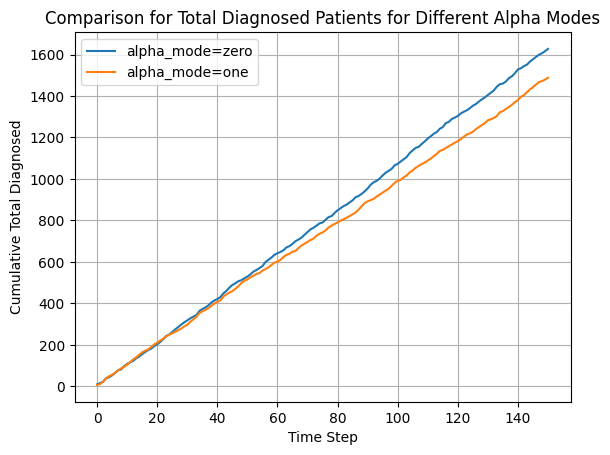

In [ ]:
plt.figure()
alpha_modes = ['zero','one']
#alpha_modes = [ 'zero','one'  ]
max_steps = 200
WGS_value = 2925.25
WGS_capacity = 1000

for alpha_mode in alpha_modes:
  print(f'Running model with alpha_mode={alpha_mode}')
  #random.seed(1000)
  model = HospitalModel(10, 10,3400, 6, 3, 1, 1, max_steps, WGS_value,WGS_capacity, alpha_mode)

  for _ in range(max_steps):
    model.step()
  # Plot the line for the current alpha mode
    #cumulative_diagnosed = np.cumsum(model.totaldiagnosed)
    series = pd.Series(model.totaldiagnosed)
    #cumulative_diagnosed = series.iloc[49:].tolist()
    cumulative_diagnosed = series.iloc[49:].cumsum().tolist()
  plt.plot(cumulative_diagnosed, label=f'alpha_mode={alpha_mode}')
    #plt.plot([sublist[2] for sublist in model.cost], label=f'alpha_mode={alpha_mode}')
    #plt.plot(sum(model.totaldiagnosed[50:]), label=f'alpha_mode={alpha_mode}')

#plt.plot(ratios, label=f'alpha_mode={alpha_mode}')
plt.title('Comparison for Total Diagnosed Patients for Different Alpha Modes')
plt.xlabel("Time Step")
plt.ylabel("Cumulative Total Diagnosed")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Model with alpha mode comparing dead patients for both scenario

Streaming output truncated to the last 5000 lines.
Total patients at Teaching Hospitals:  [5, 5, 6, 6, 4, 9, 5, 4, 2, 1, 4, 4, 4, 9, 6, 9, 11, 8, 10, 11, 7, 7, 9, 10, 6, 10, 10, 11, 8, 10, 9, 7, 14, 7, 8, 9, 14, 18, 15, 15, 10, 8, 9, 18, 12, 10, 16, 10, 8, 9, 13, 7, 8, 10, 15, 8, 15, 11, 10, 13, 11, 8, 3, 11, 13, 8, 14, 9, 12, 14, 6, 6, 16, 6, 4, 14, 16, 8, 9, 9, 10, 13, 7, 7, 12, 9, 10, 6, 10, 15, 5, 7, 5, 9, 6, 12, 15, 11, 6, 6, 9, 8, 3, 13, 15, 8, 10, 7, 7, 9, 10, 6, 13, 9, 11, 7, 16, 8, 8, 5, 7, 9, 12, 4, 7, 16, 7, 5, 9, 10, 9, 6, 10, 10, 7, 9, 4, 9, 10, 6, 13, 17, 9, 13, 9, 11, 11, 3, 3]
Total patients at Academic Hospitals:  [1, 0, 1, 2, 4, 0, 1, 2, 0, 5, 0, 1, 1, 1, 1, 5, 5, 7, 7, 4, 11, 5, 6, 2, 3, 5, 8, 5, 10, 7, 7, 6, 6, 8, 9, 5, 6, 9, 9, 5, 8, 7, 10, 5, 10, 7, 7, 15, 5, 6, 8, 10, 15, 13, 10, 9, 5, 4, 13, 8, 9, 9, 4, 8, 9, 11, 6, 5, 6, 10, 9, 10, 9, 8, 9, 7, 10, 4, 8, 12, 6, 12, 7, 7, 12, 6, 3, 14, 6, 3, 13, 11, 3, 7, 5, 10, 13, 5, 6, 9, 8, 8, 4, 7, 12, 4, 8, 5, 10, 5, 9, 14,

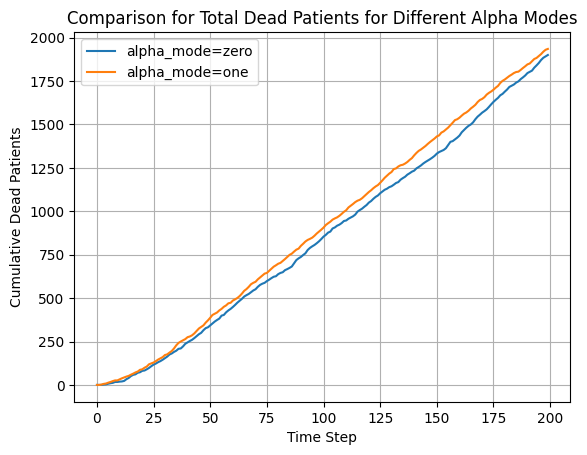

In [ ]:
plt.figure()
alpha_modes = ['zero','one']
#alpha_modes = [ 'zero','one'  ]
max_steps = 200
WGS_value = 2925.25
WGS_capacity = 4
WGS_time = 14

for alpha_mode in alpha_modes:
  print(f'Running model with alpha_mode={alpha_mode}')
  #random.seed(1000)
  model = HospitalModel(10, 10,3400, 6, 3, 1, 1, max_steps, WGS_value, WGS_capacity,  WGS_time, alpha_mode)

  for _ in range(max_steps):
    model.step()
  # Plot the line for the current alpha mode
  plt.plot([sublist[4] for sublist in model.cost], label=f'alpha_mode={alpha_mode}')

#plt.plot(ratios, label=f'alpha_mode={alpha_mode}')
plt.title('Comparison for Total Dead Patients for Different Alpha Modes')
plt.xlabel("Time Step")
plt.ylabel("Cumulative Dead Patients")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
data = [1,3,4,6,8,3,2,4,8]
series = pd.Series(data)
cumulative_sum = series.iloc[3:].cumsum().tolist()
print(cumulative_sum )

one = 3141

diagnosed patient
zero (scenario 2) = 1922
one (base scenario) =1813

dead patient
zero (scenario 2) = 1985
one (base scenario) = 2041

[6, 14, 17, 19, 23, 31]


# Model with alpha mode comparing total cumulative cost

Streaming output truncated to the last 5000 lines.
Total patients at Teaching Hospitals:  [5, 2, 3, 7, 9, 10, 3, 6, 6, 12, 5, 8, 4, 6, 9, 7, 10, 4, 6, 5, 8, 6, 8, 4, 11, 9, 6, 8, 8, 6, 7, 9, 7, 8, 9, 8, 9, 10, 2, 7, 6, 4, 6, 7, 6, 8, 9, 5, 4, 8, 5, 5, 10, 6, 7, 8, 8, 13, 9, 7, 5, 14, 8, 9, 9, 11, 3, 12, 6, 8, 8, 8, 7, 7, 5, 11, 10, 7, 10, 9, 7, 8, 9, 8, 6, 7, 5, 5, 5, 10, 11, 15, 11, 11, 4, 7, 10, 10, 7, 8, 6, 10, 5, 5, 10, 11, 10, 6, 16, 8, 8, 5, 9, 10, 3, 7, 4, 7, 10, 9, 13, 2, 9, 7, 6, 3, 9, 4, 11, 7, 9, 15, 13, 6, 8, 7, 13, 11, 10, 10, 9, 5, 8, 13, 4, 7, 11, 7, 8]
Total patients at Academic Hospitals:  [1, 2, 0, 0, 0, 1, 3, 0, 0, 0, 2, 0, 1, 0, 1, 8, 4, 5, 9, 13, 14, 6, 8, 8, 14, 8, 12, 9, 11, 13, 6, 12, 7, 10, 10, 10, 9, 9, 6, 12, 12, 8, 13, 12, 6, 7, 12, 10, 11, 13, 9, 13, 11, 4, 10, 9, 10, 7, 7, 9, 11, 7, 7, 6, 12, 8, 6, 10, 8, 12, 12, 12, 12, 8, 7, 6, 13, 9, 10, 13, 14, 5, 14, 6, 8, 10, 13, 9, 6, 7, 14, 8, 8, 11, 15, 9, 7, 9, 11, 6, 8, 9, 7, 7, 12, 10, 15, 13, 12, 6, 5, 15, 11,

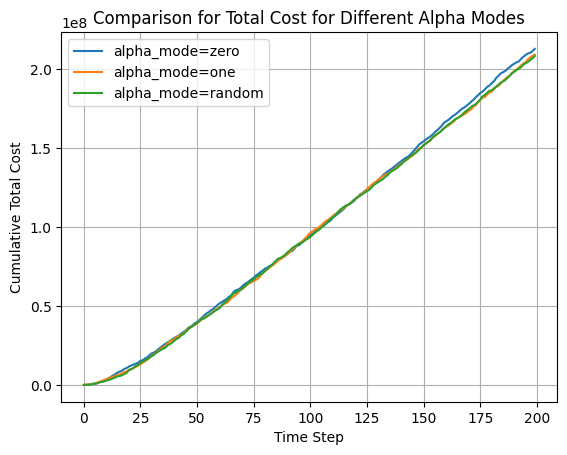

In [ ]:
plt.figure()
alpha_modes = ['zero','one', 'random']
#alpha_modes = ['zero', 'one']
max_steps = 200
WGS_value = 2925.25
WGS_capacity = 4
WGS_time = 14
for alpha_mode in alpha_modes:
    print(f'Running model with alpha_mode={alpha_mode}')
    random.seed(1000)
    model = HospitalModel(10, 10, 3400, 6, 3, 1, 1, max_steps, WGS_value, WGS_capacity,WGS_time, alpha_mode)

    for _ in range(max_steps):
        model.step()
  # Plot the line for the current alpha mode
    #cumulative_cost = np.cumsum(model.cost)
    #plt.plot(model.cost,  label=f'alpha_mode={alpha_mode}')
    plt.plot([sublist[0] for sublist in model.cost], label=f'alpha_mode={alpha_mode}')


#plt.plot(ratios, label=f'alpha_mode={alpha_mode}')
plt.title('Comparison for Total Cost for Different Alpha Modes')
plt.xlabel("Time Step")
plt.ylabel("Cumulative Total Cost")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

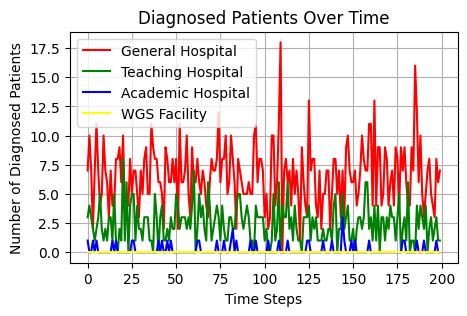

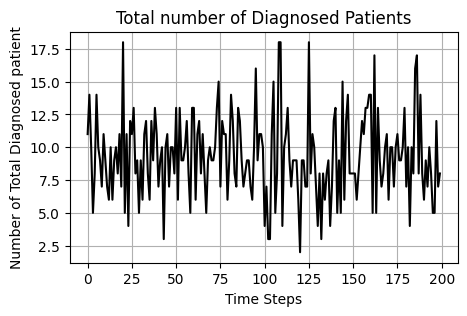

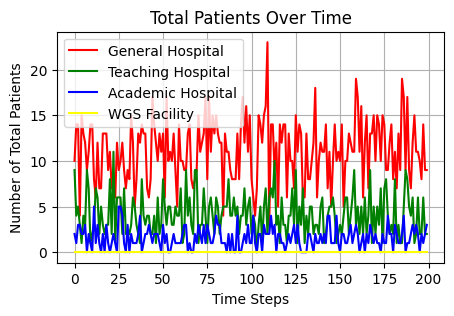

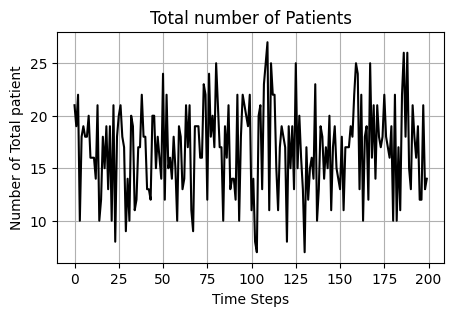

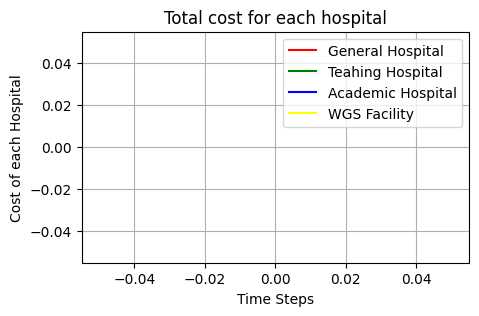

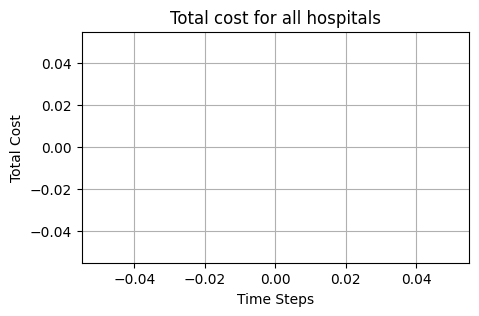

In [ ]:
#diagnosed patientst for each hospital
plt.figure(figsize=(5, 3))
plt.plot(model.diagnosed_General, label='General Hospital', color='red')
plt.plot(model.diagnosed_Teaching, label='Teaching Hospital', color='green')
plt.plot(model.diagnosed_Academic, label='Academic Hospital', color='blue')
plt.plot(model.diagnosed_WGS, label = 'WGS Facility', color = 'yellow')
plt.title('Diagnosed Patients Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Number of Diagnosed Patients')
plt.legend()
plt.grid(True)
plt.show()

#total diagnosed patient
plt.figure(figsize=(5, 3))
plt.plot(model.totaldiagnosed, label= 'total Diagnosed', color = 'black')
plt.title ('Total number of Diagnosed Patients')
plt.xlabel('Time Steps')
plt.ylabel('Number of Total Diagnosed patient')
plt.grid(True)
plt.show()

#total patient for each hospital
plt.figure(figsize=(5, 3))
plt.plot(model.total_General, label='General Hospital', color='red')
plt.plot(model.total_Teaching, label='Teaching Hospital', color='green')
plt.plot(model.total_Academic, label='Academic Hospital', color='blue')
plt.plot(model.total_wg, label= 'WGS Facility', color = 'yellow')
plt.title('Total Patients Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Number of Total Patients')
plt.legend()
plt.grid(True)
plt.show()

#total patient for all hospital
plt.figure(figsize=(5, 3))
plt.plot(model.total, label= 'total Diagnosed', color = 'black')
plt.title ('Total number of Patients')
plt.xlabel('Time Steps')
plt.ylabel('Number of Total patient')
plt.grid(True)
plt.show()

#total cost for each hospital
plt.figure(figsize = (5, 3))
plt.plot(model.totalcost_g, label = 'General Hospital', color = 'red')
plt.plot(model.totalcost_t, label = 'Teahing Hospital', color = 'green')
plt.plot(model.totalcost_a, label = 'Academic Hospital', color = 'blue')
plt.plot(model.totalcost_wgs, label = 'WGS Facility', color = 'yellow')
plt.title('Total cost for each hospital')
plt.xlabel('Time Steps')
plt.ylabel('Cost of each Hospital')
plt.legend()
plt.grid(True)
plt.show()

#total cost for all hospital
plt.figure(figsize=(5, 3))
plt.plot(model.totalcost, color = 'black')
plt.title ('Total cost for all hospitals')
plt.xlabel('Time Steps')
plt.ylabel('Total Cost')
plt.grid(True)
plt.show()

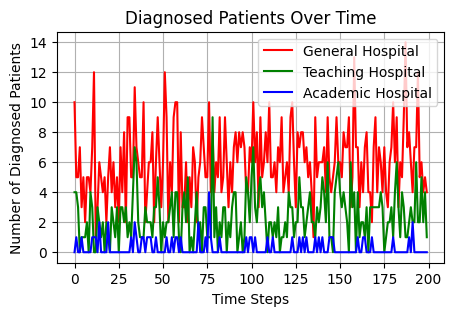

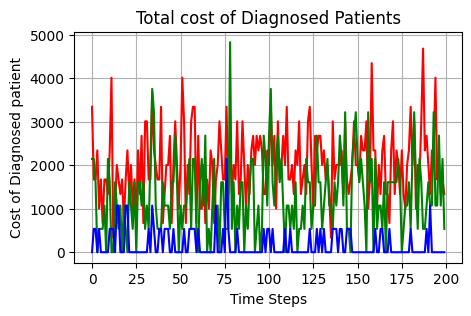

In [ ]:
#diagnosed patientst for each hospital
plt.figure(figsize=(5, 3))
plt.plot(model.diagnosed_General, label='General Hospital', color='red')
plt.plot(model.diagnosed_Teaching, label='Teaching Hospital', color='green')
plt.plot(model.diagnosed_Academic, label='Academic Hospital', color='blue')
#plt.plot(model.diagnosed_WGS, label = 'WGS Facility', color = 'yellow')
plt.title('Diagnosed Patients Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Number of Diagnosed Patients')
plt.legend()
plt.grid(True)
plt.show()

#total diagnosed patient cost
plt.figure(figsize=(5, 3))
plt.plot(model.Gdiagnosedcost, label= 'Cost of Diagnosed patient at General Hospital', color = 'red')
plt.plot(model.Tdiagnosedcost, label = 'Cost of Diagnosed patient at Teaching Hospital', color = 'green' )
plt.plot(model.Adiagnosedcost, label = 'Cost of Diagnosed patient at Academic Hospital', color = 'blue')
plt.title ('Total cost of Diagnosed Patients')
plt.xlabel('Time Steps')
plt.ylabel('Cost of Diagnosed patient')
plt.grid(True)
plt.show()

# Call visualizing function

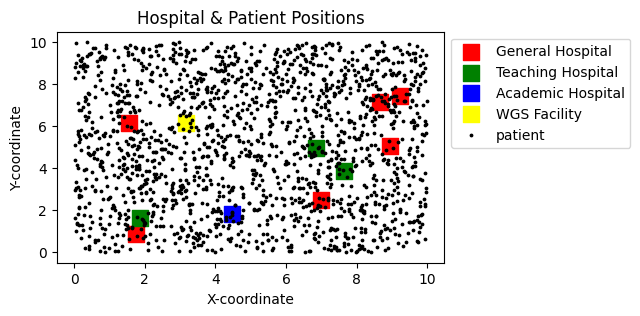

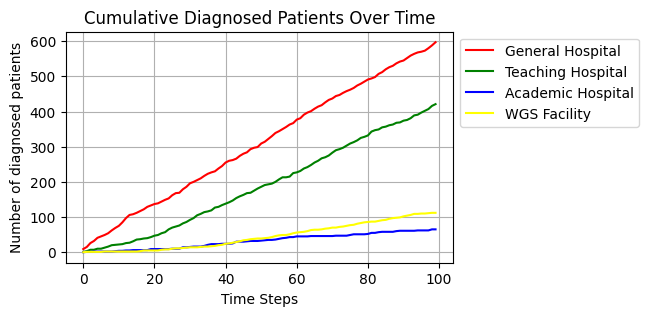

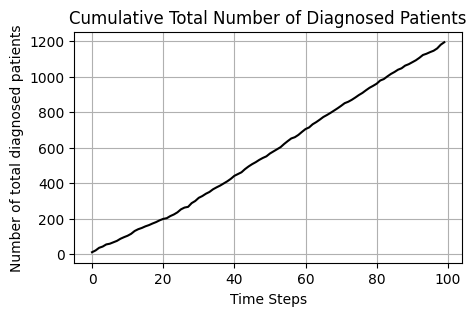

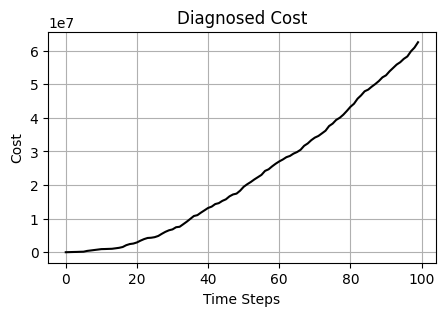

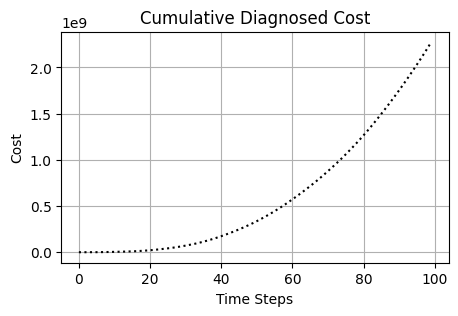

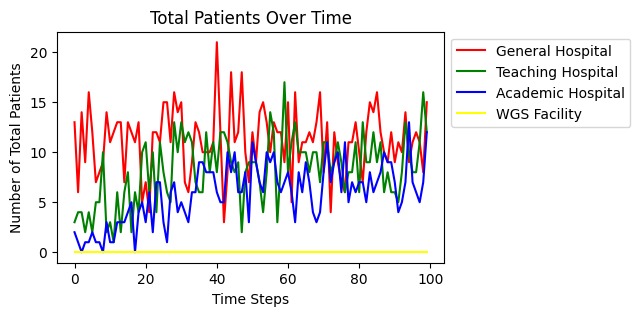

GeneralHospital 1 : 4820
GeneralHospital 2 : 1403
GeneralHospital 3 : 4536
GeneralHospital 4 : 1535
GeneralHospital 5 : 10457
GeneralHospital 6 : 1846
TeachingHospital 1 : 4077
TeachingHospital 2 : 1567
TeachingHospital 3 : 3301
AcademicHospital 1 : 6600


In [ ]:
# Visualize hospitals
model.visualize_hospitals()
# Visualize diagnosed patients for each hospital
#model.diagnosed_for_each_hospital()
model.cumulative_diagnosed_for_each_hospital()
#Visualize total diagnosed patient for all hospitals
#model.total_diagnosed()
model.cumulative_total_diagnosed()
model.diagnosed_cost()
model.cumulative_diagnosed_cost()
#model.cumulative_diagnosed_cost()
#model.cumulative_dead_p()
#model.total_cost()
#Visualize total patients for each hospital
model.total_patients_for_each_hospital()
#model.cumulative_total_patients_for_each_hospital()
#Visualize total patient for all hospitals
#model.total_patient()
#model.cumulative_patient()
#Visualize total cost for each hospital
#model.total_cost_for_each_hospital()
#model.cumulative_total_cost_for_each_hospital()
#Visualoze total cost for all hospitals
#model.total_cost()
#model.cumulative_total_cost()
model.hospitals_waitingtime()

# Model with Alpha

In [ ]:
# Create a figure for the line graph

plt.figure()
alpha_value = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
max_steps = 50
# Loop over different k values
for alpha_value in alpha_value:
    print(alpha_value)
    #random.seed(2546)
    model = HospitalModel(10,10,5, 4, 2,1, alpha_value, max_steps)

    # Run the model
    for _ in range(max_steps):
        model.step()

    # Plot the line for the current k value for total cost
        print(model.totalcost)
    plt.plot(model.totalcost, label=f'alpha={alpha_value}')

    plt.plot(model.totaldiagnosed, label=f'alpha={alpha_value}')


    # Plot the line for the current k value for total cost
        # Set labels and legend
plt.xlabel("Time")
plt.ylabel("Total cost")
plt.legend(loc='upper left')
plt.show()

plt.xlabel("Time")
plt.ylabel("Tota diagnosed patient")
plt.show()
# Display the line graph



0


TypeError: HospitalModel.__init__() missing 1 required positional argument: 'WGS_value'

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt


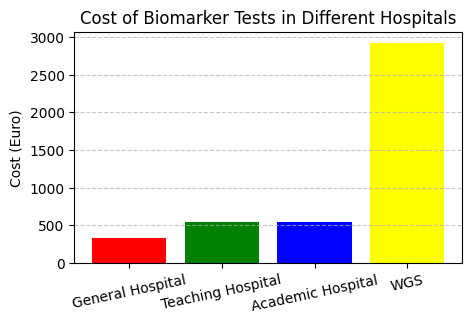

NameError: name 'bars' is not defined

In [ ]:
names = ['General Hospital', 'Teaching Hospital', 'Academic Hospital', 'WGS']
prices = [334.14, 536.02, 536.02, 2925.25]

plt.figure(figsize=(5, 3))
plt.bar(names, prices, color=['red','green', 'blue', 'yellow'])
#plt.xlabel('Type of Test')
plt.ylabel('Cost (Euro)')
plt.title('Cost of Biomarker Tests in Different Hospitals')
plt.xticks(rotation=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, yval + 2, f'{yval:.2f}', ha='center', va='bottom')

# Show the plot
plt.show()

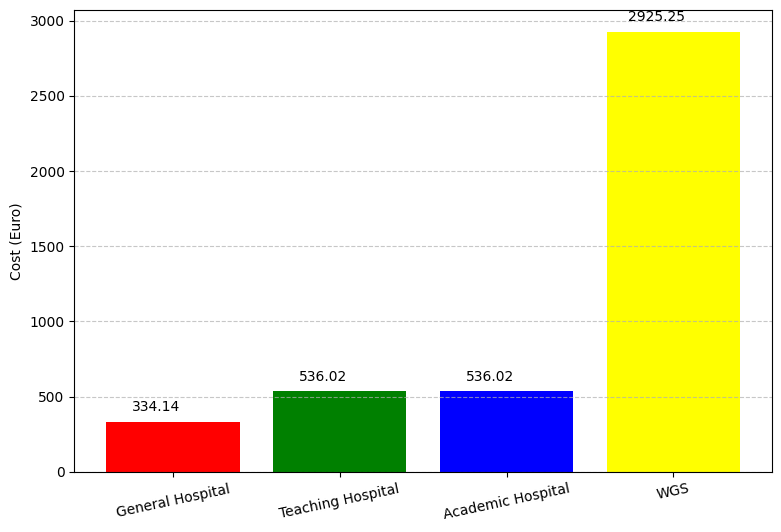

In [ ]:
import matplotlib.pyplot as plt

# Data
names = ['General Hospital', 'Teaching Hospital', 'Academic Hospital', 'WGS']
prices = [334.14, 536.02, 536.02, 2925.25]

# Create the plot
plt.figure(figsize=(9, 6))
bars = plt.bar(names, prices, color=['red','green', 'blue', 'yellow'])
plt.ylabel('Cost (Euro)')
#plt.title('Cost of Biomarker Tests in Different Hospitals')
plt.xticks(rotation=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding the cost labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2 - 0.1, yval + 50, f'{yval:.2f}', ha='center', va='bottom')
#plt.legend(bars, names)
# Show the plot
plt.show()


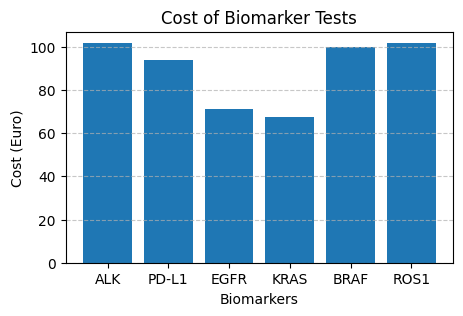

In [ ]:
import matplotlib.pyplot as plt
tests = ['ALK', 'PD-L1','EGFR','KRAS','BRAF','ROS1']
cost = [101.88, 93.74, 71.19, 67.33, 100, 101.88]
plt.figure(figsize=(5, 3))
plt.bar(tests, cost)
plt.xlabel('Biomarkers')
plt.ylabel('Cost (Euro)')
plt.title('Cost of Biomarker Tests')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()